# DSG Predictive Modelling
This notebook contains a documented and explained code for 

### Problem Statement -
* Given are 24 attributes of 'Mushrooms'
* We need to classify them as 'edible' (=e) or 'poisonous' (=p)

### Dataset Given -
* MUSHROOM Dataset
* Train Dataset - 'mushroom_train.csv'
* Test  Dataset - 'mushroom_test.csv'

### Evaluation Metric used - 
* Accuracy - Number of correct predictions / Number of total predictions

### IMPORTS

In [1]:
# Numpy and Pandas for data manipulation
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

## Label Encoding
from sklearn.preprocessing import LabelEncoder

## Cross-Validation Score
from sklearn.model_selection import cross_val_score

## Useful 'Metrics' for model evaluation
from sklearn.metrics import accuracy_score, make_scorer, roc_curve, auc

## Confusion matrix
from sklearn.metrics import confusion_matrix, classification_report

## Data Normalisation
from sklearn.preprocessing import StandardScaler

## Mode statistics
from scipy.stats import mode

## PCA tools
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Seaborn and Matplotlib for data visualisation
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### HELPER FUNCTIONS

In [2]:
def visualize_column_values(data):
    '''
    Parameter: 'data' --> the input dataframe
    
    Prints the uniques values in the dataframe (columnwise)
    '''
    
    cols = data.columns.tolist()
    # Radius and weights have been removed to prevent overcrowding display.
    cols.remove('radius')
    cols.remove('weight')

    print ("{:25}".format("COLUMN NAME"), "| UNIQUE VALUES")
    print ("-"*50)
    for col in cols:
        print ("{:25}".format(col), ": ", data[col].unique())

def num_missing(x):
    '''
    Parameter: 'x' --> list or a vector
    
    Returns the count of NULL values in given vector
    '''
    return sum(x.isnull())

def roc_curve_acc(Y_test, Y_pred,method):
    '''
    Parameter: 'Y_test' --> ground truth vector
    Parameter: 'Y_pred' --> prediction vector
    Parameter: 'method' --> (string) legend name
    
    Plots the ROC Curve
    '''
    false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_test, Y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, color='darkorange',label='%s AUC = %0.3f'%(method, roc_auc))
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'b--')
    plt.ylim([-0.1, 1.1])
    plt.xlim([-0.1, 1.1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    
def plot_feature_importance(clf, cols):
    '''
    Parameter: 'clf' --> classifier object
    Parameter: 'cols' --> feature-columns
    
    Plots the curve for 'feature importance' V/s. 'features'
    '''
    plt.figure(figsize = (10,10))
    
    imp = clf.feature_importances_
    imp, cols = zip(*sorted(zip(imp, cols)))
    plt.barh(range(len(cols)), imp, align='center')
    plt.yticks(range(len(cols)), cols)
    plt.xlabel("Importance of features")
    plt.ylabel("Feautures")
    plt.title("Importance of each feature")
    plt.show()
    
def plot_decision_boundary(clf, x, y):
    '''
    Parameter: 'clf' --> classifier object
    Parameter: 'x' --> feature-vectors
    Parameter: 'y' --> ground truth vectors
    
    Plots the decision boundary curve for given 'classifier'
    '''
    plot_step = 0.1
    
    plt.figure(figsize = (10,10))
    if x.shape[1] != 2:
        raise ValueError("X should have exactly 2 columns")
    x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                        np.arange(x_min, x_max, plot_step))
    clf.fit(x, y)
    if hasattr(clf, 'predict_proba'):
        z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    else:
        z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        
    z = z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, z, cmap=plt.cm.Reds)
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap=plt.cm.Paired)
    plt.show()
    
def plot_confusion_matrix(y, pred):
    '''
    Parameter: 'y' --> ground truth vector
    Parameter: 'pred' --> prediction vector
    
    Plots the confusion matrix for given 'preditions'
    '''
    # Confision Matrix.
    cm = confusion_matrix(y, pred)

    # Plotting using seaborn
    _ = sns.heatmap(cm, square = True, xticklabels = ['e', 'p'], annot = True, annot_kws = {'fontsize': 12}, 
                    yticklabels = ['e', 'p'], cbar = True, cbar_kws = {"orientation": "horizontal"}, 
                    cmap = "Blues").set(xlabel = "predicted", ylabel = "true", title = 'Confusion Matrix')

### LOAD DATA

Data has been loaded into two **pandas-dataframes**:
* 1st Dataframe - '**train**'
* 2nd Dataframe - '**test**'

In [3]:
# load data
train = pd.read_csv("Dataset/mushroom_train.csv")
test = pd.read_csv("Dataset/mushroom_test.csv")

### DATA OVERVIEW

##### Visualising the TRAIN dataframe

In [4]:
train.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,radius,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,weight,ring-number,ring-type,spore-print-color,population,habitat
0,p,f,s,e,f,s,f,c,n,b,t,?,215,s,k,p,w,p,w,38,o,e,w,v,l
1,p,x,y,w,t,p,f,c,n,k,e,e,94,s,s,w,w,p,w,43,o,p,n,v,u
2,e,f,s,n,t,n,f,c,b,e,e,?,244,s,s,e,e,p,w,37,t,e,w,c,w
3,p,x,s,e,f,y,f,c,n,b,t,?,286,k,s,p,w,p,w,82,o,e,w,v,l
4,e,x,s,w,t,l,f,c,b,n,e,c,110,s,s,w,w,p,w,36,o,p,n,s,m


##### Visualising the unique columns values in TRAIN dataframe

In [5]:
visualize_column_values(train)

COLUMN NAME               | UNIQUE VALUES
--------------------------------------------------
class                     :  ['p' 'e']
cap-shape                 :  ['f' 'x' 'b' 'k' 's' 'c']
cap-surface               :  ['s' 'y' 'f' 'g']
cap-color                 :  ['e' 'w' 'n' 'y' 'g' 'b' 'p' 'r' 'u' 'c']
bruises                   :  ['f' 't']
odor                      :  ['s' 'p' 'n' 'y' 'l' 'f' 'c' 'm' 'a']
gill-attachment           :  ['f' 'a']
gill-spacing              :  ['c' 'w']
gill-size                 :  ['n' 'b']
gill-color                :  ['b' 'k' 'e' 'n' 'h' 'p' 'u' 'g' 'w' 'y' 'o' 'r']
stalk-shape               :  ['t' 'e']
stalk-root                :  ['?' 'e' 'c' 'b' 'r']
stalk-surface-above-ring  :  ['s' 'k' 'f' 'y']
stalk-surface-below-ring  :  ['k' 's' 'f' 'y']
stalk-color-above-ring    :  ['p' 'w' 'e' 'g' 'b' 'c' 'n' 'o' 'y']
stalk-color-below-ring    :  ['w' 'e' 'n' 'p' 'b' 'g' 'c' 'o' 'y']
veil-type                 :  ['p']
veil-color                :  ['w' 'o' 'n

##### Visualising the TEST dataframe

In [6]:
test.head()

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,radius,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,weight,ring-number,ring-type,spore-print-color,population,habitat
0,x,f,g,t,n,f,c,b,u,t,b,32,s,s,p,g,p,w,23,o,p,k,y,d
1,x,y,g,f,f,f,c,b,g,e,b,7,k,k,b,b,p,w,23,o,l,h,v,d
2,b,s,w,t,a,f,c,b,w,e,c,2,s,s,w,w,p,w,24,o,p,k,s,m
3,f,y,y,f,f,f,c,b,p,e,b,2,k,k,n,b,p,w,53,o,l,h,y,d
4,b,y,y,t,a,f,c,b,w,e,c,10,s,s,w,w,p,w,24,o,p,k,n,m


##### Visualising the unique columns values in TEST dataframe

In [7]:
visualize_column_values(test)

COLUMN NAME               | UNIQUE VALUES
--------------------------------------------------
cap-shape                 :  ['x' 'b' 'f' 'k' 's']
cap-surface               :  ['f' 'y' 's']
cap-color                 :  ['g' 'w' 'y' 'p' 'n' 'e' 'r' 'b' 'c' 'u']
bruises                   :  ['t' 'f']
odor                      :  ['n' 'f' 'a' 'c' 'y' 'l' 's' 'p' 'm']
gill-attachment           :  ['f' 'a']
gill-spacing              :  ['c' 'w']
gill-size                 :  ['b' 'n']
gill-color                :  ['u' 'g' 'w' 'p' 'h' 'n' 'b' 'e' 'k' 'r' 'y' 'o']
stalk-shape               :  ['t' 'e']
stalk-root                :  ['b' 'c' '?' 'e' 'r']
stalk-surface-above-ring  :  ['s' 'k' 'f' 'y']
stalk-surface-below-ring  :  ['s' 'k' 'f' 'y']
stalk-color-above-ring    :  ['p' 'b' 'w' 'n' 'o' 'e' 'g' 'c']
stalk-color-below-ring    :  ['g' 'b' 'w' 'o' 'p' 'n' 'e' 'c' 'y']
veil-type                 :  ['p']
veil-color                :  ['w' 'o' 'n']
ring-number               :  ['o' 't' 'n']
ring-

Observation: The dataset has missing values ("?") in 'stalk-root' column of both TEST and TRAIN data

In [8]:
train['stalk-root'].value_counts().to_dict(), test['stalk-root'].value_counts().to_dict()

({'?': 1727, 'b': 2665, 'c': 382, 'e': 780, 'r': 132},
 {'?': 753, 'b': 1111, 'c': 174, 'e': 340, 'r': 60})

Observation: There are 1727 missing values from TRAIN data and 753 missing values from TEST data

### How BIG is the dataset ?

In [9]:
print ("Train data : ", len(train), 'records')
print ("Test  data : ", len(test), 'records')

Train data :  5686 records
Test  data :  2438 records


### DATA PRE-PROCESSING
* Since the column entries are *string*, not numeric.
* We need to *encode* them to numeric values

In [10]:
# Prepare a list of categorical-feature columns
cols = train.columns.tolist()

## Since this is target-column, we will process it afterwards
cols.remove("class")

## These columns already have numeric values
cols.remove("radius")
cols.remove("weight")

# Label Encode the categorical features
for col in cols:
    lbl = LabelEncoder()
    train[col] = lbl.fit_transform(train[col])
    test[col] = lbl.transform(test[col])
    if col == 'stalk-root':
        print (lbl.classes_)

['?' 'b' 'c' 'e' 'r']


Observation: The '?' value have been label encoded to '0'




In [11]:
# set target variable
train['class'] = [1 if x == 'p' else 0 for x in train['class']]

In [12]:
# Replace the '?' with NaN values
train['stalk-root'].replace(0, np.nan, inplace=True)
test['stalk-root'].replace(0, np.nan, inplace=True)

# Impute the missing values ('?') using 'mode-statistics'
train['stalk-root'].fillna(mode(train['stalk-root']).mode[0], inplace=True)
test['stalk-root'].fillna(mode(test['stalk-root']).mode[0], inplace=True)

Now, the dataset has been prepared
* missing values have been filled
* all values are encoded to numeric values
  
  
In the label class:
* 0 means 'edible'
* 1 means 'poisonous'

In [13]:
# Un-comment to verify yourself
#print ("Missing values per column: ")
#print (train.apply(num_missing, axis=0))

### CORRELATION MATRIX

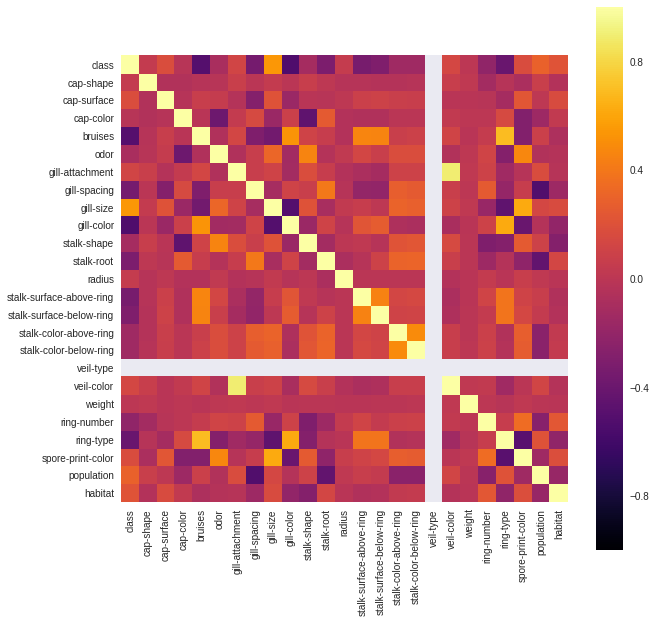

In [14]:
plt.figure(figsize = (10,10))
sns.heatmap(train.corr(), cmap = 'inferno',square=True)
plt.show()

Observation: column 'veil-type' shows a different behaviour in above table because there is only a **single value** in this column and hence the std-dev is zero.

### FEATURE EXTRACTION

* Train features are in nd-array '**x**'
* Train labels are in nd-array '**y**'

In [15]:
# Feature columns
cols = train.columns.tolist()
cols.remove('class')

# Prepare the dataset as nd-arrays
x = (train.drop(['class', 'veil-type'], axis=1)).as_matrix()
y = train['class'].as_matrix()

### DATA NORMALISATION

In [16]:
# MEAN has been subtracted from dataset 
# and has been divided by STD-DEV
# to scale the data from -1 to 1
scaler = StandardScaler()
x = scaler.fit_transform(x)

### PCA

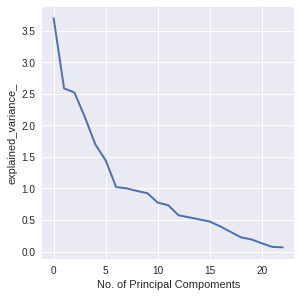

In [17]:
# Visualising the PCA spectrum
pca = PCA()
pca.fit(x)

plt.figure(1, figsize=(5, 5))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_,  linewidth=2)
plt.axis('tight')
plt.xlabel('No. of Principal Compoments')
plt.ylabel('explained_variance_')
plt.show()

Observation: The shape of the curve is **NOT** very *steep*, so neglecting the features is **NOT** a good option.

#### Visualising the data in 2-Dimensions

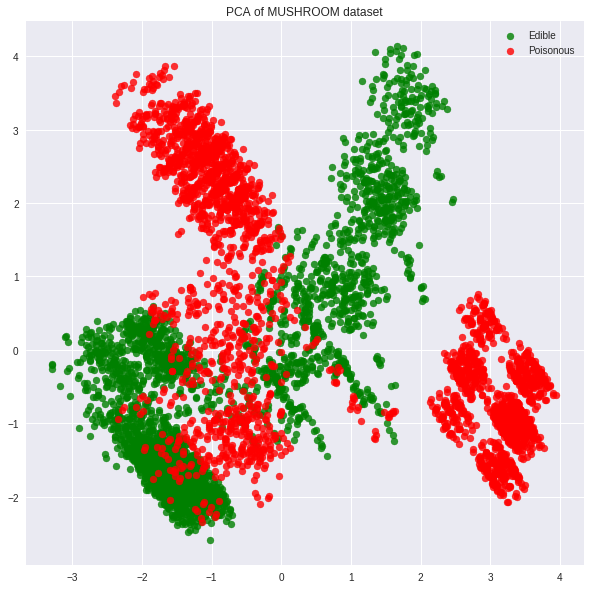

In [18]:
pca = PCA(n_components=2)
pca_x = pca.fit_transform(x)

colors = ['green', 'red']
plt.figure(figsize = (10,10))
for color, i, target_name in zip(colors, [0, 1], y):
    plt.scatter(pca_x[y == i, 0], pca_x[y == i, 1], color=color, alpha=.8,label=y)
plt.legend(['Edible', 'Poisonous'])
plt.title('PCA of MUSHROOM dataset')
plt.show()

The above model shows the '**scatter-plot**' of two kinds of mushrooms

### Various Models

#### Logistic Regression

Cross-Val Score [ 0.97012302  0.95954266  0.96833773  0.96394019  0.96569921]

[Logistic Regression] Accuracy:  0.969046781569


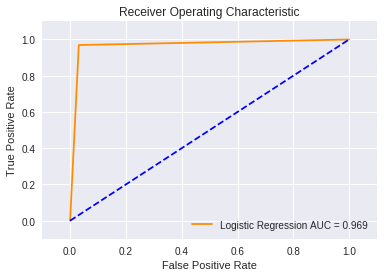

In [19]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
# Check cross-val score
print("Cross-Val Score", cross_val_score(clf, x, y, cv=5, scoring=make_scorer(accuracy_score)))
# Train Model
clf.fit(x, y)
pred = clf.predict(x)
print ("\n[Logistic Regression] Accuracy: ", accuracy_score(y, pred))

# Plots
#plot_feature_importance(clf, cols)  [not applicable]
#plot_decision_boundary(clf, pca_x, y)
roc_curve_acc(y, pred, "Logistic Regression")

Inference - 
* The cross-val score and accuracy approximately match -> meaning the model is free from bias/variable
* Max possible accuracy is ~96.9 %

#### Decision Trees

Cross-Val Score [ 1.  1.  1.  1.  1.]

[Decision Trees] Accuracy:  1.0


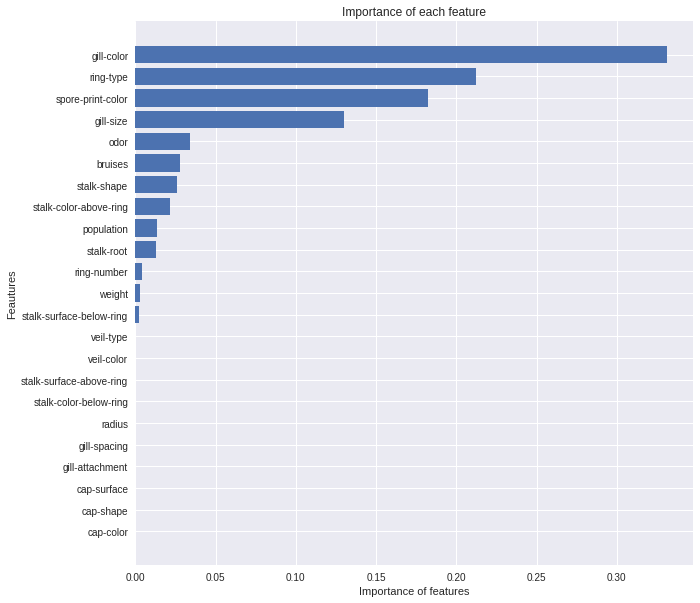

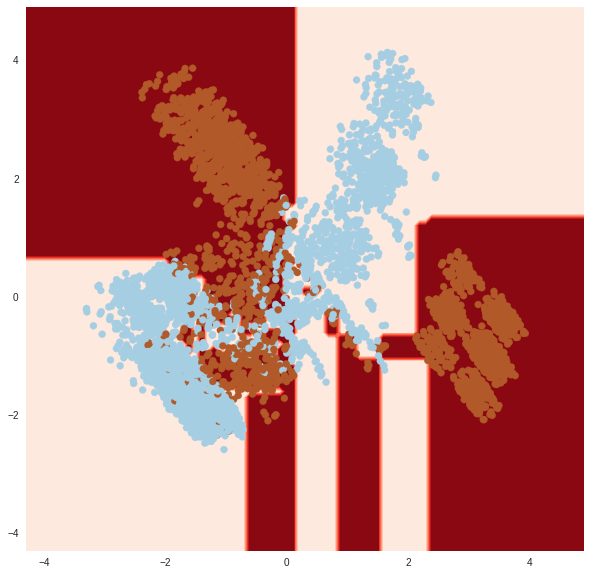

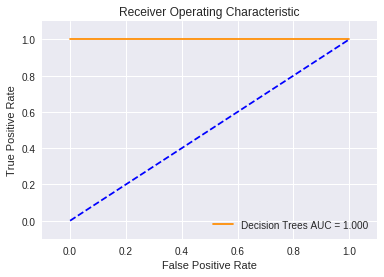

In [20]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
# Check cross-val score
print("Cross-Val Score", cross_val_score(clf, x, y, cv=5, scoring=make_scorer(accuracy_score)))
# Train Model
clf.fit(x, y)
pred = clf.predict(x)
print ("\n[Decision Trees] Accuracy: ", accuracy_score(y, pred))

# Plots
plot_feature_importance(clf, cols)
plot_decision_boundary(clf, pca_x, y)
roc_curve_acc(y, pred, "Decision Trees")

Inference - 
* The cross-val score and accuracy approximately match -> meaning the model is free from bias/variable
* Important features are marked in 'important-feature-plot'
* Eg: gill-color, ring-type, etc are important distinguishing features
* Decision boundary has been visualised and we can infer that this boundary well distinguishes the target labels to give such HIGH accuracy
* Max possible accuracy is ~100 %

#### Support Vector Machines (SVMs)

Cross-Val Score [ 1.          0.99912049  0.99912049  1.          1.        ]

[SVM] Accuracy:  0.999648258881


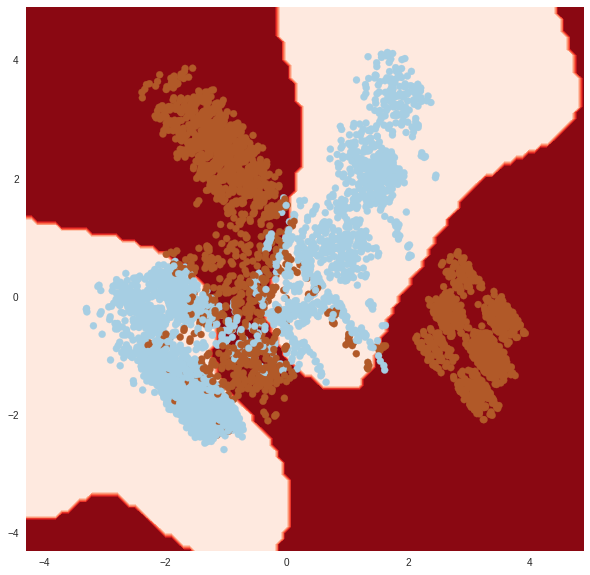

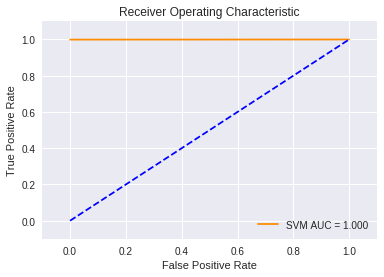

In [21]:
### SVM
from sklearn import svm
clf = svm.SVC()
# Check cross-val score
print("Cross-Val Score", cross_val_score(clf, x, y, cv=5, scoring=make_scorer(accuracy_score)))
# Train Model
clf.fit(x, y)
pred = clf.predict(x)
print ("\n[SVM] Accuracy: ", accuracy_score(y, pred))

# Plots
#plot_feature_importance(clf, cols)  [not applicable]
plot_decision_boundary(clf, pca_x, y)
roc_curve_acc(y, pred, "SVM")

Inference - 
* The cross-val score and accuracy approximately match -> meaning the model is free from bias/variable
* Decision boundary has been visualised and we can infer that this boundary well distinguishes the target labels to give such HIGH accuracy
* Some datapoints are not distinguished be boundary, hence not giving full 100% accuracy as in 'Decision-Trees'
* Max possible accuracy is ~99.99 %

#### XGBoost

/home/gtmchoudhary/anaconda3/envs/gputf/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Cross-Val Score [ 1.  1.  1.  1.  1.]

[XGBoost] Accuracy:  1.0


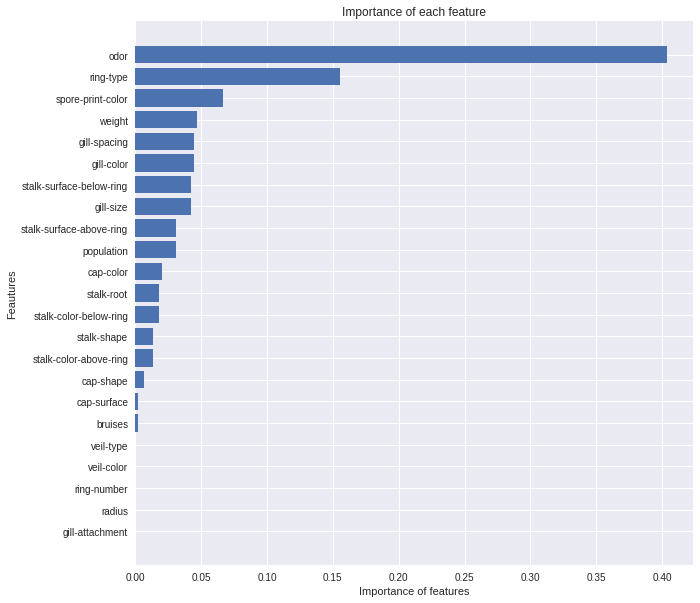

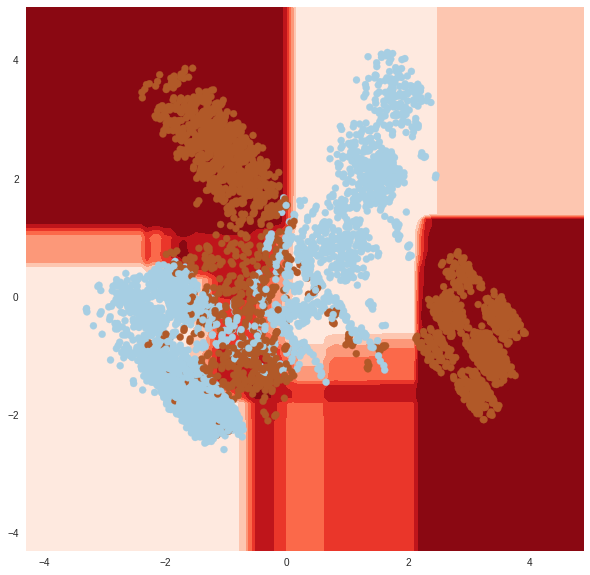

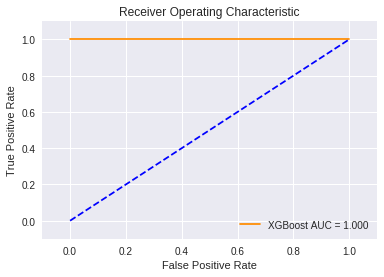

In [22]:
import xgboost
clf = xgboost.XGBClassifier()
# Check cross-val score
print("Cross-Val Score", cross_val_score(clf, x, y, cv=5, scoring=make_scorer(accuracy_score)))
# Train Model
clf.fit(x, y)
pred = clf.predict(x)
print ("\n[XGBoost] Accuracy: ",accuracy_score(y, pred))

# Plots
plot_feature_importance(clf, cols)
plot_decision_boundary(clf, pca_x, y)
roc_curve_acc(y, pred, "XGBoost")

Inference - 
* The cross-val score and accuracy approximately match -> meaning the model is free from bias/variable
* Important features are marked in 'important-feature-plot'
* 'odor' and 'ring-type' are highly distinguishing features
* Decision boundary has been visualised and we can infer that this boundary well distinguishes the target labels to give such HIGH accuracy
* Max possible accuracy is ~100 %

#### Naive Bayes

Cross-Val Score [ 0.90773286  0.91380827  0.9058927   0.91116974  0.89885664]
Accuracy:  0.909954273655


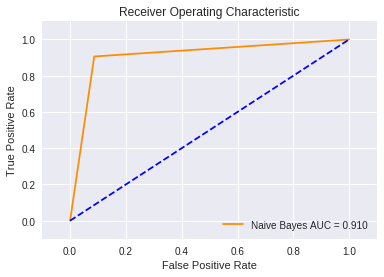

In [23]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
# Check cross-val score
print("Cross-Val Score", cross_val_score(clf, x, y, cv=5, scoring=make_scorer(accuracy_score)))
# Train Model
clf.fit(x, y)
pred = clf.predict(x)
print ("Accuracy: ",accuracy_score(y, pred))

# Plots
#plot_feature_importance(clf, cols)  [not applicable]
#plot_decision_boundary(clf, pca_x, y)
roc_curve_acc(y, pred, "Naive Bayes")

Inference - 
* The cross-val score and accuracy approximately match -> meaning the model is free from bias/variable
* Max possible accuracy is ~90.9 %

#### Various other models can also been applied for this CLASSIFICATION problem:
* MLP
* RandomForest
* LightGBM
* CatBoost
* AdaBoost
* ExtraTreeClassifier
* GBM

## Visualising highly distinguishing features

As clear from 'important-feature-plots' above, we can say that 'odor' and 'spore-print-color' are very higly distinguishing features for our model. This is clear from the COUNT_PLOTs shown below.  
Notice how each type of odor (encoded as 0,1,2,....8) easily distinguishes a class.

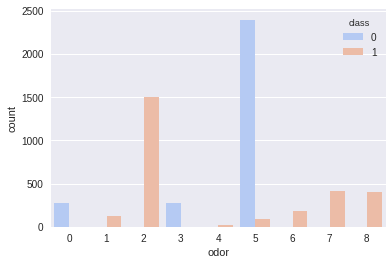

In [24]:
sns.countplot(x = 'odor', data = train, hue='class', palette='coolwarm')
plt.show()

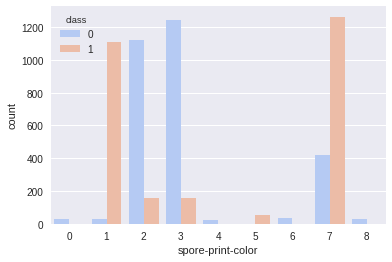

In [25]:
sns.countplot(x = 'spore-print-color', data = train, hue='class', palette='coolwarm')
plt.show()

## Visualising less distinguishing features

As clear from 'important-feature-plots' above, there are some less distinguishing features like 'gill-attachment', 'veil-color', 'weight', 'radius', etc. This is clear from the COUNT_PLOTs shown below.  
Notice how each type of feature vector (encoded as 0,1,...) barely distinguishes a class.

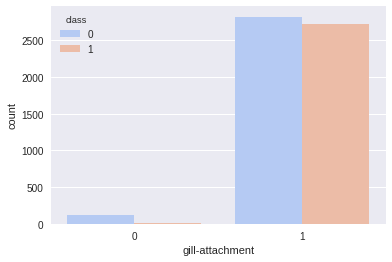

In [26]:
sns.countplot(x = 'gill-attachment', data = train, hue='class', palette='coolwarm')
plt.show()

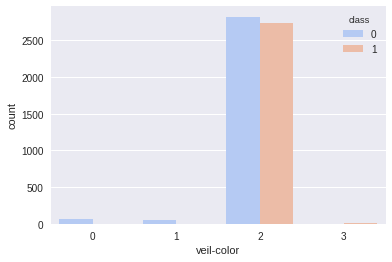

In [27]:
sns.countplot(x = 'veil-color', data = train, hue='class', palette='coolwarm')
plt.show()

# --------------------------------------- END ---------------------------------------